# Caffe学习系列：caffemodel可视化

通过前面的学习，我们已经能够正常训练各种数据了。设置好solver.prototxt后，我们可以把训练好的模型保存起来，如lenet_iter_10000.caffemodel。训练多少次就自动保存一下，这个是通过snapshot进行设置的，保存文件的路径及文件名前缀是由snapshot_prefix来设定的。这个文件里面存放的就是各层的参数，即net.params，里面没有数据(net.blobs)。顺带还生成了一个相应的solverstate文件，这个和caffemodel差不多，但它多了一些数据，如模型名称、当前迭代次数等。两者的功能不一样，训练完后保存起来的caffemodel，是在测试阶段用来分类的，而solverstate是用来恢复训练的，防止意外终止而保存的快照(有点像断点续传的感觉)。

既然我们知道了caffemodel里面保存的就是模型各层的参数，因此我们可以把这些参数提取出来，进行可视化，看一看究竟长什么样。

我们先训练cifar10数据(mnist也可以)，迭代10000次，然后将训练好的model保存起来，名称为cifar10_full_iter_10000.caffemodel，然后使用jupyter notebook来进行可视化。

首先，导入必要的库：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, caffe
%matplotlib inline

caffe_root = '/root/Repository/caffe/'
os.chdir(caffe_root)
sys.path.insert(0, caffe_root + 'python')

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

设置网络模型，并显示该模型中各层名称和参数的规模(注意此处是net.params，而不是net.blobs)：

In [2]:
net = caffe.Net(caffe_root + 'examples/cifar10/cifar10_full.prototxt',
                caffe_root + 'examples/cifar10/cifar10_full_iter_10000.caffemodel',
                caffe.TEST)
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (10, 1024))]

cifar10训练的模型配置在文件cifar10_full.prototxt里面，共有三个卷积层和一个全连接层，参数规模如上所示。

In [3]:
# 编写一个函数，用于显示各层的参数
def show_feature(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data)
    plt.axis('off')

(32, 3, 5, 5)


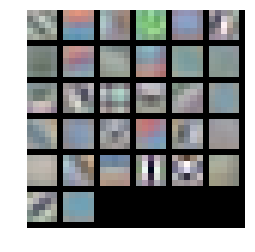

In [4]:
# 第一个卷积层，参数规模为(32, 3, 5, 5)，即32个5*5的3通道filter
weight = net.params["conv1"][0].data
print(weight.shape)
show_feature(weight.transpose(0, 2, 3, 1))

参数有两种类型：权值参数和偏置项。分别用params\["conv1"\]\[0\]和params\["conv1"\]\[1\]表示。我们只显示权值参数，因此用params\["conv1"\]\[0\]。

(32, 32, 5, 5)


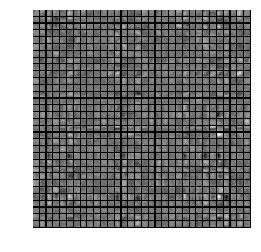

In [5]:
# 第二个卷积层的权值参数，共有32*32个filter，每个filter大小为5*5
weight = net.params["conv2"][0].data
print(weight.shape)
show_feature(weight.reshape(32 ** 2, 5, 5))

(64, 32, 5, 5)


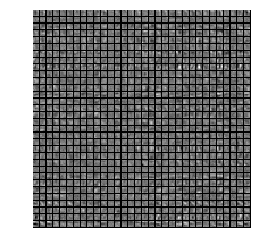

In [6]:
# 第三个卷积层的权值，共有64*32个filter，每个filter大小为5*5，取其前1024个进行可视化
weight = net.params["conv3"][0].data
print(weight.shape)
show_feature(weight.reshape(64 * 32, 5, 5)[:1024])